In [1]:
from pandas import read_excel, DataFrame, read_csv, Series
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
#from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score
import pylab as pl
import time # для работы со временем
import pandas.io.sql as psql
import pickle # для сохранения/загр
from numpy import object,append
import datetime
import matplotlib.pyplot as plt
# заставляем рисунки встраиваться в блокнот
%matplotlib inline


/home/zaspa_ay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [2]:
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["NLS_LANG"] = "Russian.AL32UTF8"  
import cx_Oracle
import pandas.io.sql as psql

#oracle_connect = pd.read_excel('mikhaylova_ekvl/Desktop/Oracle.xlsx')
#oracle_connect = pd.read_excel('/home/MACC/cx_Oracle_connect.xlsx')
#oracle_connect

In [3]:
log = 'MIKHAYLOVA_EKVL[PxU_DCBUL_UMA_MOD]'
pas = 'Kate0806+++'
or_tns = 'DATALAB'

print(log)
print(pas)
print(or_tns)

MIKHAYLOVA_EKVL[PxU_DCBUL_UMA_MOD]
Kate0806+++
DATALAB


In [4]:
# для чтения из sql
tns = or_tns
conn = cx_Oracle.connect(log, pas, tns)
c = conn.cursor()

sqlStr6 = ('''select * from ev_ev_block_finish_copy''')
train = pd.read_sql(sqlStr6, conn) 

In [3]:
# чтение из эксель
w = {'INN': np.object} 
train = pd.read_excel(open('BLOCK_TRAIN.xlsx', 'rb'),dtype = w)

train

FileNotFoundError: [Errno 2] No such file or directory: 'BLOCK_TRAIN.xlsx'

In [5]:
train = train.drop_duplicates('INN')
train.shape

(394832, 109)

In [6]:
train['TRANSACT_FLG'] = train['TRANSACT_FLG'].fillna(value=0)
train['CREDIT_FLG'] = train['CREDIT_FLG'].fillna(value=0)
train['DEPOSITS_FLG'] = train['DEPOSITS_FLG'].fillna(value=0)
train['ELECTR_GARANTEE'] = train['ELECTR_GARANTEE'].fillna(value=0)

train['ACT_FL'] = train['TRANSACT_FLG'] + train['CREDIT_FLG'] + train['DEPOSITS_FLG'] + train['ELECTR_GARANTEE']

In [7]:
# экспертная выборка с метками
w = {'ИНН': np.object} 
f2 = pd.read_excel(open('marks2902_2.xlsx', 'rb'),dtype = w)
f2

,Дата,ИНН,Хороший или плохой,Сброс НДС,Обнал
0,2020-02-29,7743270352,плохой,ДА,ДА
1,2020-02-29,784101042678,плохой,ДА,ДА
2,2020-02-29,3528310415,плохой,ДА,ДА
3,2020-02-29,2463109898,плохой,ДА,ДА
4,2020-02-29,7460047593,плохой,ДА,ДА
...,...,...,...,...,...
60516,2020-02-29,2464011084,хороший,NaN,NaN
60517,2020-02-29,6608003013,хороший,NaN,NaN
60518,2020-02-29,7808019220,хороший,NaN,NaN
60519,2020-02-29,2456001491,хороший,NaN,NaN


In [8]:
# оставляем только хороших и плохих

f2 = f2[(f2['Хороший или плохой'].notna()) & (f2['Хороший или плохой']!='серый') & (f2['Хороший или плохой']!='непонятный')]

# целевой признак (по экспернтой оценке)

f2['TARGET1'] = np.where((f2['Хороший или плохой']=='плохой') | (f2['Хороший или плохой']=='Плохой'),1,0)
f2['TARGET1'].value_counts()

0    16342
1    10913
Name: TARGET1, dtype: int64

In [9]:
# объединение с экспертной оценкой
train = pd.merge(train,f2[['ИНН','TARGET1']],left_on='INN',right_on='ИНН',how='left')

In [10]:
# итоговый целевой признак
train['TARGET_BLOCK'] = np.where((train['TARGET']==1) | (train['TARGET1']==1),1,0)
train['TARGET_BLOCK'].value_counts()

0    380906
1     13926
Name: TARGET_BLOCK, dtype: int64

In [11]:
# выбираем активных клиентов, у которых есть хотя бы один р/сч и кто не заблокирован на 29.02
train = train[(train['COUNT_R']>0) & (train['ACT_FL']>0) & (train['TARGET_PAST']!=1)]
train['TARGET_BLOCK'].value_counts(),train.shape

(0    167834
 1      7431
 Name: TARGET_BLOCK, dtype: int64,
 (175265, 113))

In [12]:
'''s = test.isnull().sum()/test.shape[0]*100
s[s>80].index'''

's = test.isnull().sum()/test.shape[0]*100\ns[s>80].index'

In [13]:
# признак ЮЛ или ИП
train['FLAG_PO_INN'] = np.where(train['INN'].map(lambda x: len(x))==10,1,0)
train['FLAG_PO_INN'] = train['FLAG_PO_INN'].astype('int')

# корректировка опечаток в СПАРКЕ, избавляемся от минусов перед выручкой
for i in ['REVENUE_SPARK','REVENUE1']:
    train[i] = np.abs(train[i])

train['OPEN_DELTA'] = train['OPEN_DT_MAX']-train['OPEN_DT_MIN'] # период между открытием первого и последнего счета

# заполнение пустых значений медианами
train['AGE_COMP'] = train['AGE_COMP'].fillna(train['AGE_COMP'].median())
train['OPEN_DT_MAX'] = train['OPEN_DT_MAX'].fillna(train['OPEN_DT_MAX'].median())
train['OPEN_DELTA'] = train['OPEN_DELTA'].fillna(train['OPEN_DELTA'].median())

train.loc[(train['CHARTER_CAPITAL'].isna()) & (train['FLAG_PO_INN']==1), 'CHARTER_CAPITAL'] = train['CHARTER_CAPITAL'].median()
train['CHARTER_CAPITAL']  = train['CHARTER_CAPITAL'].fillna(value=0)
train['CHARTER_CAPITAL'] = train['CHARTER_CAPITAL'].astype('int')

In [14]:
#test['OGRN_DAY_FOR_OPEN'] = test['AGE_COMP'] - test['OPEN_DT_MAX'] # в каком возрасте (компании) клиент пришел в банк
#test['OPEN_DELTA'] = test['OPEN_DT_MAX']-test['OPEN_DT_MIN'] # период между открытием первого и последнего счета

In [15]:
train['COMPANY_SIZE_DESCRIPTION'].value_counts()

Микропредприятие       65568
Малые предприятия       6165
Средние предприятия      951
Крупные предприятия      337
Name: COMPANY_SIZE_DESCRIPTION, dtype: int64

In [16]:
train.loc[(train['COMPANY_SIZE_DESCRIPTION']=='Микропредприятие'), 'COMPANY_SIZE_DESCRIPTION'] = 1
train.loc[(train['COMPANY_SIZE_DESCRIPTION']=='Малые предприятия'), 'COMPANY_SIZE_DESCRIPTION'] = 2
train.loc[(train['COMPANY_SIZE_DESCRIPTION']=='Средние предприятия'), 'COMPANY_SIZE_DESCRIPTION'] = 3
train.loc[(train['COMPANY_SIZE_DESCRIPTION']=='Крупные предприятия'), 'COMPANY_SIZE_DESCRIPTION'] = 4

In [17]:
train.loc[(train['COMPANY_SIZE_DESCRIPTION'].isna()) & (train['FLAG_PO_INN']==1), 'COMPANY_SIZE_DESCRIPTION'] = train['COMPANY_SIZE_DESCRIPTION'].median()
train['COMPANY_SIZE_DESCRIPTION'] = train['COMPANY_SIZE_DESCRIPTION'].fillna(0)
train['COMPANY_SIZE_DESCRIPTION'] = train['COMPANY_SIZE_DESCRIPTION'].astype(int)

In [18]:
# признак дробления платежа
train['DROB'] = np.where(train['MAX_SUM_DROB']>0,1,0)
train['DROB1'] = np.where(train['MAX_SUM_DROB1']>0,1,0)

train['PRIME_CATEGORY'] = np.where(train['PRIME_CATEGORY']=='Малый',1,0)
train['PRIME_CATEGORY'] = train['PRIME_CATEGORY'].astype(int)

# динимические показатели

train['CREDm01'] = train['CREDIT_M']/train['CREDIT_M_1']

train['CREDm01_max'] = train['CREDIT_MAX_M']/train['CREDIT_MAX_M_1']
train['DEBm01'] = train['DEBET_M']/train['DEBET_M_1']
train['DEBm01_max'] = train['DEBET_MAX_M']/train['DEBET_MAX_M_1']
train['COUNT_TRNS'] = train['DEBET_TRANS_M']+train['CREDIT_TRANS_M']

train['DEP01'] = train['DEP_M']/train['DEP_M1']
train['CR/DB'] = train['CREDIT_M']/train['DEBET_M']
train['DVS01'] = train['DVS_AVG_M']/train['DVS_AVG_M_1']

train['BEZ+S_NDS'] = np.where((train['S_NDS']>=0.7) & (train['BEZ_NDS']>=0.5),1,0)

train['SUM_DROB_PLAT3/'] = train['SUM_DROB_PLAT3']/train['SUM_DEBET3']
train['SUM_LITTLE_PLAT3/'] = train['SUM_LITTLE_PLAT3']/train['SUM_DEBET3']
train['SUM_IP3/'] = train['SUM_IP3']/train['SUM_DEBET3']
train['SUM_FIZ3/'] = train['SUM_FIZ3']/train['SUM_DEBET3']

train['CASH_DEBET_WEEK'] = train['CASH_WEEK']/train['DEBET_WEEK']
train['CASH_DEBET_MONTH'] = train['CASH_MONTH']/train['DEBET_MONTH']

#train['CR/DB_WEEK'] = train['CREDIT_WEEK']/train['DEBET_WEEK']
train['CR/DB_MONTH'] = train['CREDIT_MONTH']/train['DEBET_MONTH']

train['CORP_OPER_WEEK'] = (train['BUY_CORP_WEEK']+train['CASH_CORP_WEEK'])/train['DEBET_WEEK']
train['CORP_OPER_MONTH'] = (train['BUY_CORP_MONTH']+train['CASH_CORP_MONTH'])/train['DEBET_MONTH']
train['CONTR/'] = train['COUNT_CONTR_SPIS']/train['COUNT_CONTR_ZACH']

In [19]:
train['NALOG6/'] = train['NALOG_6']/train['CREDIT_6']
train['NALOG12/'] = train['NALOG_12']/train['CREDIT_12']

train['1'] = train['TAXES_SUM']/train['REVENUE1']

for i in ['REVENUE_SPARK','WORKERS_RANGE','PROFIT_REVENUE1','PROFIT1',
 'REVENUE1','CR/DB_MONTH','CONTR/','CR/DB','CREDm01_max',
 'DEBm01_max','CREDm01','DEBm01','DEP01','DVS01','1']:
    train[i] = train[i].fillna(-1000)

zero = ['NALOG_12','NALOG_6','SUM_CONTR_ZACH','DVS_AVG_M','NOM_CONTROL','CREDIT_MONTH',
 'SUM_CONTR_SPIS','CREDIT_MAX_M','DEBET_MAX_M','SUM_FIZ3',
 'DEBET_TRANS_M','SUM_DEBET3','COUNT_CONTR_ZACH','GROUP_CNT',
 'DEBET_MONTH','DOLYA_SUM_BAD_SPIS','DOLYA_BAD_SPIS','DOLYA_BAD_ZACH','SUM_ZP3','DOLYA_SUM_BAD_ZACH',
 'CASH_CORP','SUM_IP3','SUM_PRODUCT','CREDIT_TRANS_M','CASH_MONTH','COUNT_CONTR_SPIS',
 'OKVED_DIFFERENT','NALOG_M_PRIB12','BUY_CORP','CASH_CORP_MONTH','REGION_DIF','BUY_CORP_MONTH',
 'DEBET_MIN_M','COUNT_ACCT','FLAG_BAD3_CONTR','DENY78',
 'SMS','EQUAR','NALOG_M_PRIB','FLAG_BAD_IP_CONTR','FLAG_BAD2_CONTR','PLEDGE','ROZNITSA',
 'DENY9','MANAGER_INN_COUNT','CORP_CARD','BEZ_NDS','S_NDS','ACT_FL',
 'ELECTR_GARANTEE','TRANSACT_FLG','DEPOSITS_FLG','FLAG_BAD1_CONTR',
 'NSO','COUNT_R','COUNT_V','RKO','BSS','IP_VEER','ACC_CUR','HOZ_PLAT','FIZ_VEER_WEEK',
 'FIZ_VEER','NEDOSTOVER','IP_VEER_WEEK','DEPP','OVERDRAFT','CREDIT_FLG','CASH_WEEK',
 'ADDRESS_COUNT','ADDRESS_FTS_COUNT','ADDRESS_NOTAFFILIATED_COUNT',
 'ADDRESS_WITHOUTROOM_COUNT','TELEPHONE_COUNT','MANAGER_COUNT_IN_COUNTRY','MANAGER_COUNT_IN_REGION',
 'TAXES_SUM','DEP_M','CREDIT_M', 'CREDIT_M_1',
       'CREDIT_MAX_M_1', 'DVS_AVG_M_1', 'DEBET_MAX_M_1', 'DEBET_M_1',
       'SUM_DROB_PLAT3', 'SUM_LITTLE_PLAT3', 'CREDIT_6', 'CREDIT_12',
       'DEBET_M', 'BUY_CORP_WEEK', 'CASH_CORP_WEEK','SUM_DROB_PLAT3/','SUM_LITTLE_PLAT3/', 'SUM_IP3/', 'SUM_FIZ3/', 'CASH_DEBET_WEEK',
           'CASH_DEBET_MONTH', 'CORP_OPER_WEEK', 'CORP_OPER_MONTH', 'NALOG6/',
           'NALOG12/','TARGET']

for i in zero:
    train[i] = train[i].fillna(0)

train['TARGET'].value_counts()

0    170346
1      4919
Name: TARGET, dtype: int64

In [20]:
# чтение из эксель (6 недельных тестовых срезов)
w = {'INN': np.object} 
test1 = pd.read_excel(open('block2301.xlsx', 'rb'),dtype = w)
test2 = pd.read_excel(open('block3001.xlsx', 'rb'),dtype = w)
test3 = pd.read_excel(open('block0602.xlsx', 'rb'),dtype = w)
test4 = pd.read_excel(open('block1302.xlsx', 'rb'),dtype = w)
test5 = pd.read_excel(open('block2002.xlsx', 'rb'),dtype = w)
test6 = pd.read_excel(open('block2702.xlsx', 'rb'),dtype = w)

In [21]:
test = pd.concat([test1,test2,test3,test4,test5,test6],axis=0)

In [23]:
del test1
del test2
del test3
del test4
del test5
del test6

##### обучение модели с target_block (блокировки + эксперт. разметка)

In [473]:
x_train_def = train.drop(['TARGET_PAST','TARGET_BLOCK','INN',
 'BUY_CORP_WEEK',
 'CASH_CORP_WEEK',
 'CORP_OPER_WEEK',
 'COUNT_TRNS',
 'CREDIT_12',
 'CREDIT_6',
 'CREDIT_M',
 'CREDIT_MAX_M_1',
 'CREDIT_M_1',
 'DDATE',
 'DEBET_M',
 'DEBET_MAX_M_1',
 'DEBET_M_1',
 'DEBET_WEEK',
 'DEP_M1',
 'DVS_AVG_M_1',
 'MAX_SUM_DROB',
 'MAX_SUM_DROB1',
 #'OGRN_DAY_FOR_OPEN',
 'OPEN_DT_MIN',
 'SUM_DROB_PLAT3',
 'SUM_LITTLE_PLAT3',
 'TARGET',
 'TARGET1',
 'ИНН',
 'ИНН', 'TARGET1',
 'SMS', 'PLEDGE', 'DENY9', 'CORP_CARD', 'ELECTR_GARANTEE', 
'DEPOSITS_FLG', 'NSO', 'RKO', 'ACC_CUR', 'FIZ_VEER_WEEK', 
 'DEPP', 'OVERDRAFT', 'CREDIT_FLG', 'COMPANY_SIZE_DESCRIPTION', 'FLAG_PO_INN'],axis=1)
y_train = train['TARGET_BLOCK']

x_valid_def = test[x_train_def.columns]
y_valid = test['TARGET']

In [474]:
# удаление признаков, по которым выборка нерепрезентативна
x_train_def.drop(['SUM_PRODUCT','BSS',
'OPEN_DT_MAX',
'OKVED_DIFFERENT',
'NALOG12/',
'ROZNITSA',
'FIZ_VEER',
'DEP01',
'DROB',
'IP_VEER',
'NALOG6/',
'COUNT_R'],axis=1,inplace=True)

In [475]:
# замена бесконечностей
for i in x_train_def.columns:
    x_train_def[i] = np.where(x_train_def[i]==float('inf'),77777777777,x_train_def[i])
    x_train_def[i] = np.where(x_train_def[i]==-float('inf'),-77777777777,x_train_def[i])

for i in x_valid_def.columns:
    x_valid_def[i] = np.where(x_valid_def[i]==float('inf'),77777777777,x_valid_def[i])
    x_valid_def[i] = np.where(x_valid_def[i]==-float('inf'),-77777777777,x_valid_def[i])

In [476]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train_def, y_train,test_size=0.3,stratify=y_train,random_state=70)
y_train1.value_counts(),y_test1.value_counts()

(0    117483
 1      5202
 Name: TARGET_BLOCK, dtype: int64,
 0    50351
 1     2229
 Name: TARGET_BLOCK, dtype: int64)

In [477]:
# отбор признаков с помощью модели 
estimator = lgb.LGBMClassifier(random_state = 2,n_jobs = 12)

estimator.fit(x_train1,y_train1)

etc_pred = estimator.predict_proba(x_test1)
etc_pred_test11 = etc_pred[:,1]

importances = pd.DataFrame({'feature':x_test1.columns,'importance':np.round(estimator.feature_importances_,0)})
importances = importances.sort_values('importance',ascending=False)

features = list(importances['feature'])
importances

,feature,importance
3,AGE_COMP,142
0,NALOG_12,113
4,SUM_CONTR_ZACH,101
73,DVS01,92
11,DEBET_MAX_M,80
6,DVS_AVG_M,78
8,CREDIT_MONTH,78
76,SUM_LITTLE_PLAT3/,73
10,CREDIT_MAX_M,72
64,DEP_M,70


In [479]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score
x = []
gini_train = []
gini_test = []
gini_val = []

for i in features:
    x.append(i)
    estimator.fit(x_train1[x],y_train1)
    train_pred = estimator.predict_proba(x_train1[x])[:,1]
    test_pred = estimator.predict_proba(x_test1[x])[:,1]
    test_valid = estimator.predict_proba(x_valid_def[x])[:,1]
    gini_train.append(np.round(2*roc_auc_score(y_train1, train_pred)-1,5))
    gini_test.append(np.round(2*roc_auc_score(y_test1, test_pred)-1,5))
    gini_val.append(np.round(2*roc_auc_score(y_valid, test_valid)-1,5))

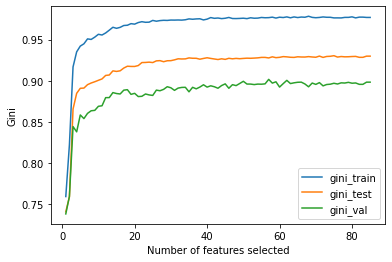

In [481]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Gini")
plt.plot(np.arange(1,len(x)+1), gini_train)
plt.plot(np.arange(1,len(x)+1), gini_test)
plt.plot(np.arange(1,len(x)+1), gini_val)
plt.legend(['gini_train','gini_test','gini_val'])
plt.show()

In [355]:
[round(x,2) for x in gini_val].index(max([round(x,2) for x in gini_val]))

38

In [482]:
features_new = features[:38]
len(features_new)

38

In [483]:
features_new

['AGE_COMP',
 'NALOG_12',
 'SUM_CONTR_ZACH',
 'DVS01',
 'DEBET_MAX_M',
 'DVS_AVG_M',
 'CREDIT_MONTH',
 'SUM_LITTLE_PLAT3/',
 'CREDIT_MAX_M',
 'DEP_M',
 'DEBET_MONTH',
 'ADDRESS_WITHOUTROOM_COUNT',
 'DEBET_TRANS_M',
 'S_NDS',
 'SUM_CONTR_SPIS',
 'CR/DB',
 'DOLYA_BAD_ZACH',
 'SUM_FIZ3',
 'DEBm01',
 'CR/DB_MONTH',
 'GROUP_CNT',
 'CASH_CORP',
 'SUM_DEBET3',
 'CONTR/',
 'CREDIT_TRANS_M',
 'DOLYA_SUM_BAD_SPIS',
 'CREDm01',
 'OPEN_DELTA',
 'CHARTER_CAPITAL',
 '1',
 'BEZ_NDS',
 'NOM_CONTROL',
 'DOLYA_SUM_BAD_ZACH',
 'NALOG_6',
 'CASH_MONTH',
 'REVENUE1',
 'SUM_ZP3',
 'EQUAR']

In [484]:
# модель на отобранных факторах

x_train1 = x_train1[features_new]
x_test1 = x_test1[features_new]
x_valid = x_valid_def[features_new]

x_train = x_train_def[features_new]

In [485]:
estimator = lgb.LGBMClassifier(random_state = 2,n_jobs = 12)

estimator.fit(x_train1,y_train1)

LGBMClassifier(n_jobs=12, random_state=2)

In [486]:
pr = 0.5
y_train_prob = estimator.predict_proba(x_train1)[:,1] 
y_test_prob = estimator.predict_proba(x_test1)[:,1] 
y_val_prob = estimator.predict_proba(x_valid)[:,1]

y_train_pred = np.where(y_train_prob >= pr,1,0) 
y_test_pred = np.where(y_test_prob >= pr,1,0)
y_val_pred = np.where(y_val_prob >= pr,1,0)

train_metrics = [np.round(precision_score(y_train1, y_train_pred),3)
,np.round(recall_score(y_train1, y_train_pred),3)
, np.round(accuracy_score(y_train1, y_train_pred),3)
,np.round(roc_auc_score(y_train1, y_train_prob),3)
,np.round(2*roc_auc_score(y_train1, y_train_prob)-1,3)]

test_metrics = [np.round(precision_score(y_test1, y_test_pred),3)
,np.round(recall_score(y_test1, y_test_pred),3)
, np.round(accuracy_score(y_test1, y_test_pred),3)
,np.round(roc_auc_score(y_test1, y_test_prob),3)
,np.round(2*roc_auc_score(y_test1, y_test_prob)-1,3)]

val_metrics = [np.round(precision_score(y_valid, y_val_pred),3)
,np.round(recall_score(y_valid, y_val_pred),3)
, np.round(accuracy_score(y_valid, y_val_pred),3)
,np.round(roc_auc_score(y_valid, y_val_prob),3)
,np.round(2*roc_auc_score(y_valid, y_val_prob)-1,3)]

In [487]:
# кросс-валидация
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
scores = cross_validate(estimator,x_train,y_train, cv=skf,scoring=['precision','recall','roc_auc','accuracy'])

print(pd.DataFrame({'test_precision' : scores['test_precision'],'test_recall' : scores['test_recall'],\
                    'test_roc_auc' : scores['test_roc_auc']}).T)

                       0         1         2
test_precision  0.720801  0.719259  0.709660
test_recall     0.523214  0.517158  0.522002
test_roc_auc    0.965647  0.964395  0.963818


In [488]:
cross = [np.round(scores['test_precision'].mean(),4),np.round(scores['test_recall'].mean(),4),np.round(scores['test_accuracy'].mean(),4),
np.round(scores['test_roc_auc'].mean(),4),np.round(2*scores['test_roc_auc'].mean()-1,4)]
pd.DataFrame({'metrics' : ['precision','recall','accuracy','roc_auc','gini'],'train': train_metrics,
             'test' : test_metrics, 'val' : val_metrics,'cross_val_score' : cross})

,metrics,train,test,val,cross_val_score
0,precision,0.810,0.715,0.485,0.7166
1,recall,0.607,0.512,0.471,0.5208
2,accuracy,0.977,0.971,0.964,0.9709
3,roc_auc,0.988,0.963,0.946,0.9646
4,gini,0.975,0.926,0.892,0.9292


#### подбор гиперпараметров

In [240]:
'''# подбор параметров
from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate':[0.01,0.05], 'num_iterations' : [100,300,500,1000,1500,2000],
              'num_leaves' : [30,60,100,150,250,350], 'max_depth' : [5,8,10,15,20]
             }

clf = GridSearchCV(estimator, parameters,scoring = 'roc_auc',cv = 3)
clf.fit(x_train, y_train)
clf.best_score_,clf.best_params_'''

NameError: name 'clf_best_params_' is not defined

In [241]:
clf.best_score_,clf.best_params_ # результат GridSearch

(0.9664010324259756,
 {'learning_rate': 0.01,
  'max_depth': 15,
  'num_iterations': 1500,
  'num_leaves': 30})

In [489]:
# обучение с оптимальными параметрами
params = ({'learning_rate': 0.01,
  'max_depth': 15,
  'num_iterations': 1500,
  'num_leaves': 30})

estimator = lgb.LGBMClassifier(random_state = 2,n_jobs = 12).set_params(**params)

estimator.fit(x_train1,y_train1)

LGBMClassifier(learning_rate=0.01, max_depth=15, n_jobs=12, num_iterations=1500,
               num_leaves=30, random_state=2)

In [490]:
pr = 0.5
y_train_prob = estimator.predict_proba(x_train1)[:,1] 
y_test_prob = estimator.predict_proba(x_test1)[:,1] 
y_val_prob = estimator.predict_proba(x_valid)[:,1]

y_train_pred = np.where(y_train_prob >= pr,1,0) 
y_test_pred = np.where(y_test_prob >= pr,1,0)
y_val_pred = np.where(y_val_prob >= pr,1,0)

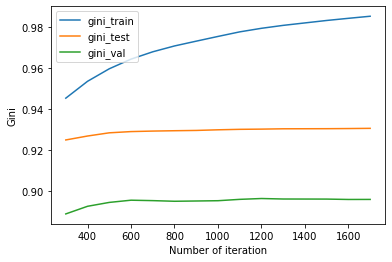

In [494]:
# подбор количества итераций
num_iters = []
gini_train = []
gini_test = []
gini_val = []

for i in [300,400,500,600,700,800,900,1000,1100,1200,1300,1500,1600,1700]:
    num_iters.append(i)
    params['num_iterations'] = i
    estimator.set_params(**params).fit(x_train1,y_train1)
    train_pred = estimator.predict_proba(x_train1)[:,1]
    test_pred = estimator.predict_proba(x_test1)[:,1]
    test_valid = estimator.predict_proba(x_valid)[:,1]
    gini_train.append(np.round(2*roc_auc_score(y_train1, train_pred)-1,5))
    gini_test.append(np.round(2*roc_auc_score(y_test1, test_pred)-1,5))
    gini_val.append(np.round(2*roc_auc_score(y_valid, test_valid)-1,5))


plt.figure()
plt.xlabel("Number of iteration")
plt.ylabel("Gini")
plt.plot(num_iters, gini_train)
plt.plot(num_iters, gini_test)
plt.plot(num_iters, gini_val)
plt.legend(['gini_train','gini_test','gini_val'])
plt.show()

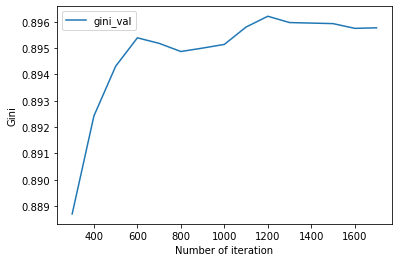

In [499]:
plt.figure()
plt.xlabel("Number of iteration")
plt.ylabel("Gini")
#plt.plot(num_iters, gini_test)
plt.plot(num_iters, gini_val)
plt.legend(['gini_val'])
plt.show()

In [500]:
# изменим количество итераций
params['num_iterarions'] = 1200

estimator = lgb.LGBMClassifier(random_state = 2,n_jobs = 12).set_params(**params)

estimator.fit(x_train1,y_train1)

LGBMClassifier(learning_rate=0.01, max_depth=15, n_jobs=12, num_iterarions=1200,
               num_iterations=1700, num_leaves=30, random_state=2)

In [501]:
pr = 0.5
y_train_prob = estimator.predict_proba(x_train1)[:,1] 
y_test_prob = estimator.predict_proba(x_test1)[:,1] 
y_val_prob = estimator.predict_proba(x_valid)[:,1]

y_train_pred = np.where(y_train_prob >= pr,1,0) 
y_test_pred = np.where(y_test_prob >= pr,1,0)
y_val_pred = np.where(y_val_prob >= pr,1,0)

train_metrics = [np.round(precision_score(y_train1, y_train_pred),3)
,np.round(recall_score(y_train1, y_train_pred),3)
, np.round(accuracy_score(y_train1, y_train_pred),3)
,np.round(roc_auc_score(y_train1, y_train_prob),3)
,np.round(2*roc_auc_score(y_train1, y_train_prob)-1,3)]

test_metrics = [np.round(precision_score(y_test1, y_test_pred),3)
,np.round(recall_score(y_test1, y_test_pred),3)
, np.round(accuracy_score(y_test1, y_test_pred),3)
,np.round(roc_auc_score(y_test1, y_test_prob),3)
,np.round(2*roc_auc_score(y_test1, y_test_prob)-1,3)]

val_metrics = [np.round(precision_score(y_valid, y_val_pred),3)
,np.round(recall_score(y_valid, y_val_pred),3)
, np.round(accuracy_score(y_valid, y_val_pred),3)
,np.round(roc_auc_score(y_valid, y_val_prob),3)
,np.round(2*roc_auc_score(y_valid, y_val_prob)-1,3)]

In [504]:
# кросс-валидация

#skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
#scores = cross_validate(estimator,x_train,y_train, cv=skf,scoring=['precision','recall','roc_auc','accuracy'])

pd.DataFrame({'test_precision' : scores['test_precision'],'test_recall' : scores['test_recall'],\
                    'test_roc_auc' : scores['test_roc_auc']})

,test_precision,test_recall,test_roc_auc
0,0.738202,0.530480,0.967386
1,0.729563,0.526040,0.965637
2,0.726867,0.526443,0.964438


In [503]:
cross = [np.round(scores['test_precision'].mean(),4),np.round(scores['test_recall'].mean(),4),np.round(scores['test_accuracy'].mean(),4),
np.round(scores['test_roc_auc'].mean(),4),np.round(2*scores['test_roc_auc'].mean()-1,4)]
pd.DataFrame({'metrics' : ['precision','recall','accuracy','roc_auc','gini'],'train': train_metrics,
             'test' : test_metrics, 'val' : val_metrics,'cross_val_score' : cross})

,metrics,train,test,val,cross_val_score
0,precision,0.857,0.724,0.483,0.7315
1,recall,0.660,0.526,0.480,0.5277
2,accuracy,0.981,0.971,0.964,0.9718
3,roc_auc,0.993,0.965,0.948,0.9658
4,gini,0.985,0.930,0.896,0.9316


In [505]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_valid, y_val_pred)

array([[1092118,   20861],
       [  21136,   19484]])

#### обучение модели без экспертной разметки клиентов

In [506]:
# изменяем целевой признак

y_train = train['TARGET']
y_valid = test['TARGET']

train['TARGET'].value_counts()

0    170346
1      4919
Name: TARGET, dtype: int64

In [507]:
x_train_def.shape,x_valid_def.shape

((175265, 85), (1153599, 97))

In [508]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train_def, y_train,test_size=0.3,stratify=y_train,random_state=70)
y_train1.value_counts(),y_test1.value_counts()

(0    119242
 1      3443
 Name: TARGET, dtype: int64,
 0    51104
 1     1476
 Name: TARGET, dtype: int64)

In [509]:
# отбор признаков
estimator = lgb.LGBMClassifier(random_state = 2,n_jobs = 12)

estimator.fit(x_train1,y_train1)

etc_pred = estimator.predict_proba(x_test1)
etc_pred_test11 = etc_pred[:,1]

In [510]:
importances = pd.DataFrame({'feature':x_test1.columns,'importance':np.round(estimator.feature_importances_,0)})
importances = importances.sort_values('importance',ascending=False)


features = list(importances['feature'])
importances

,feature,importance
3,AGE_COMP,173
4,SUM_CONTR_ZACH,122
0,NALOG_12,120
6,DVS_AVG_M,96
73,DVS01,94
8,CREDIT_MONTH,74
64,DEP_M,71
11,DEBET_MAX_M,70
10,CREDIT_MAX_M,68
57,ADDRESS_WITHOUTROOM_COUNT,65


In [511]:
x = []
gini_train = []
gini_test = []
gini_val = []

for i in features:
    x.append(i)
    estimator.fit(x_train1[x],y_train1)
    train_pred = estimator.predict_proba(x_train1[x])[:,1]
    test_pred = estimator.predict_proba(x_test1[x])[:,1]
    test_valid = estimator.predict_proba(x_valid_def[x])[:,1]
    gini_train.append(np.round(2*roc_auc_score(y_train1, train_pred)-1,5))
    gini_test.append(np.round(2*roc_auc_score(y_test1, test_pred)-1,5))
    gini_val.append(np.round(2*roc_auc_score(y_valid, test_valid)-1,5))
    

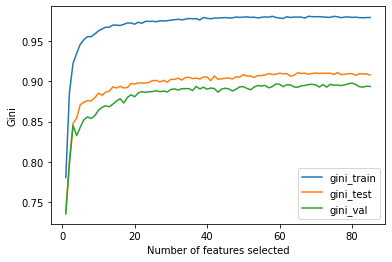

In [516]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Gini")
plt.plot(np.arange(1,len(x)+1), gini_train)
plt.plot(np.arange(1,len(x)+1), gini_test)
plt.plot(np.arange(1,len(x)+1), gini_val)
plt.legend(['gini_train','gini_test','gini_val'])
plt.show()

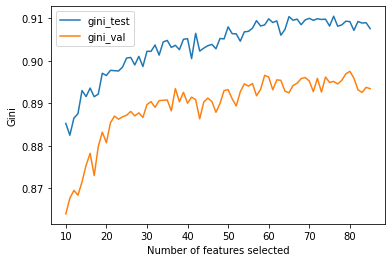

In [517]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Gini")
plt.plot(np.arange(10,len(x)+1), gini_test[9:])
plt.plot(np.arange(10,len(x)+1), gini_val[9:])
plt.legend(['gini_test','gini_val'])
plt.show()

In [518]:
[round(x,2) for x in gini_val].index(max([round(x,2) for x in gini_val]))

58

In [519]:
features_new = features[:58]
len(features_new)

58

In [521]:
features_new

['AGE_COMP',
 'SUM_CONTR_ZACH',
 'NALOG_12',
 'DVS_AVG_M',
 'DVS01',
 'CREDIT_MONTH',
 'DEP_M',
 'DEBET_MAX_M',
 'CREDIT_MAX_M',
 'ADDRESS_WITHOUTROOM_COUNT',
 'SUM_FIZ3',
 'SUM_LITTLE_PLAT3/',
 'CONTR/',
 'CASH_CORP',
 'DEBET_MONTH',
 'DOLYA_BAD_SPIS',
 'SUM_CONTR_SPIS',
 'TAXES_SUM',
 'DOLYA_SUM_BAD_ZACH',
 'SUM_DEBET3',
 'GROUP_CNT',
 'CR/DB',
 'COUNT_CONTR_ZACH',
 'BEZ_NDS',
 'DOLYA_BAD_ZACH',
 'DEBET_TRANS_M',
 'CREDm01_max',
 'NALOG_6',
 'CASH_WEEK',
 'S_NDS',
 '1',
 'CREDIT_TRANS_M',
 'CR/DB_MONTH',
 'CREDm01',
 'DOLYA_SUM_BAD_SPIS',
 'SUM_IP3/',
 'SUM_IP3',
 'CHARTER_CAPITAL',
 'PROFIT1',
 'SUM_FIZ3/',
 'SUM_DROB_PLAT3/',
 'EQUAR',
 'DEBm01',
 'OPEN_DELTA',
 'COUNT_CONTR_SPIS',
 'HOZ_PLAT',
 'DEBET_MIN_M',
 'NALOG_M_PRIB12',
 'NOM_CONTROL',
 'BUY_CORP',
 'SUM_ZP3',
 'REVENUE_SPARK',
 'REVENUE1',
 'CASH_DEBET_MONTH',
 'DENY78',
 'COUNT_ACCT',
 'BUY_CORP_MONTH',
 'CORP_OPER_MONTH']

In [522]:
# обучение с отобранными факторами

x_train1 = x_train1[features_new]
x_test1 = x_test1[features_new]
x_valid = x_valid_def[features_new]

x_train = x_train_def[features_new]

In [523]:
estimator = lgb.LGBMClassifier(random_state = 2,n_jobs = 12,scale_pos_weight = 2)

estimator.fit(x_train1,y_train1)

LGBMClassifier(n_jobs=12, random_state=2, scale_pos_weight=2)

In [524]:
pr = 0.5
y_train_prob = estimator.predict_proba(x_train1)[:,1] 
y_test_prob = estimator.predict_proba(x_test1)[:,1] 
y_val_prob = estimator.predict_proba(x_valid)[:,1]

y_train_pred = np.where(y_train_prob >= pr,1,0) 
y_test_pred = np.where(y_test_prob >= pr,1,0)
y_val_pred = np.where(y_val_prob >= pr,1,0)

train_metrics = [np.round(precision_score(y_train1, y_train_pred),3)
,np.round(recall_score(y_train1, y_train_pred),3)
, np.round(accuracy_score(y_train1, y_train_pred),3)
,np.round(roc_auc_score(y_train1, y_train_prob),3)
,np.round(2*roc_auc_score(y_train1, y_train_prob)-1,3)]

test_metrics = [np.round(precision_score(y_test1, y_test_pred),3)
,np.round(recall_score(y_test1, y_test_pred),3)
, np.round(accuracy_score(y_test1, y_test_pred),3)
,np.round(roc_auc_score(y_test1, y_test_prob),3)
,np.round(2*roc_auc_score(y_test1, y_test_prob)-1,3)]

val_metrics = [np.round(precision_score(y_valid, y_val_pred),3)
,np.round(recall_score(y_valid, y_val_pred),3)
, np.round(accuracy_score(y_valid, y_val_pred),3)
,np.round(roc_auc_score(y_valid, y_val_prob),3)
,np.round(2*roc_auc_score(y_valid, y_val_prob)-1,3)]

In [525]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
scores = cross_validate(estimator,x_train,y_train, cv=skf,scoring=['precision','recall','roc_auc','accuracy'])

print(pd.DataFrame({'test_precision' : scores['test_precision'],'test_recall' : scores['test_recall'],\
                    'test_roc_auc' : scores['test_roc_auc']}).T)

                       0         1         2
test_precision  0.510094  0.536005  0.520315
test_recall     0.462195  0.481098  0.484442
test_roc_auc    0.954538  0.960566  0.956938


In [526]:
cross = [np.round(scores['test_precision'].mean(),4),np.round(scores['test_recall'].mean(),4),np.round(scores['test_accuracy'].mean(),4),
np.round(scores['test_roc_auc'].mean(),4),np.round(2*scores['test_roc_auc'].mean()-1,4)]
pd.DataFrame({'metrics' : ['precision','recall','accuracy','roc_auc','gini'],'train': train_metrics,
             'test' : test_metrics, 'val' : val_metrics,'cross_val_score' : cross})

,metrics,train,test,val,cross_val_score
0,precision,0.667,0.500,0.565,0.5221
1,recall,0.635,0.453,0.389,0.4759
2,accuracy,0.981,0.972,0.968,0.9731
3,roc_auc,0.989,0.955,0.948,0.9573
4,gini,0.978,0.910,0.896,0.9147


In [527]:
p = 0.5
y_val_pred = np.where(y_val_prob >= p,1,0)

confusion_matrix(y_valid, y_val_pred)

array([[1100799,   12180],
       [  24813,   15807]])

In [282]:
# подбор параметров
'''from sklearn.model_selection import GridSearchCV

parameters = {'learning_rate':[0.01,0.05], 'num_iterations' : [100,300,500,1000,1500,2000],
              'num_leaves' : [30,60,100,150,250,350], 'max_depth' : [5,8,10,15,20]
             }

clf = GridSearchCV(estimator, parameters,scoring = 'roc_auc',cv = 3)
clf.fit(x_train, y_train)
clf.best_score_,clf.best_params_'''

(0.9593559484894856,
 {'learning_rate': 0.01,
  'max_depth': 10,
  'num_iterations': 1000,
  'num_leaves': 30})

In [529]:
params = ({'learning_rate': 0.01,
  'max_depth': 10,
  'num_iterations': 1000,
  'num_leaves': 30})

estimator = lgb.LGBMClassifier(random_state = 2,n_jobs = 12,scale_pos_weight = 2.5).set_params(**params)

estimator.fit(x_train1,y_train1)

LGBMClassifier(learning_rate=0.01, max_depth=10, n_jobs=12, num_iterations=1000,
               num_leaves=30, random_state=2, scale_pos_weight=2.5)

#### подбор количества итераций

In [530]:
num_iters = []
gini_train = []
gini_test = []
gini_val = []

for i in [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]:
    num_iters.append(i)
    params['num_iterations'] = i
    estimator.set_params(**params).fit(x_train1,y_train1)
    train_pred = estimator.predict_proba(x_train1)[:,1]
    test_pred = estimator.predict_proba(x_test1)[:,1]
    test_valid = estimator.predict_proba(x_valid)[:,1]
    gini_train.append(np.round(2*roc_auc_score(y_train1, train_pred)-1,5))
    gini_test.append(np.round(2*roc_auc_score(y_test1, test_pred)-1,5))
    gini_val.append(np.round(2*roc_auc_score(y_valid, test_valid)-1,5))

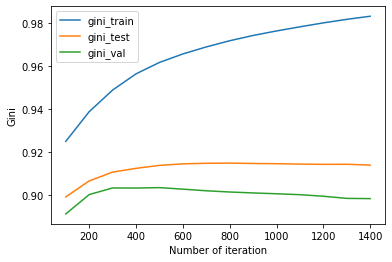

In [531]:
plt.figure()
plt.xlabel("Number of iteration")
plt.ylabel("Gini")
plt.plot(num_iters, gini_train)
plt.plot(num_iters, gini_test)
plt.plot(num_iters, gini_val)
plt.legend(['gini_train','gini_test','gini_val'])
plt.show()

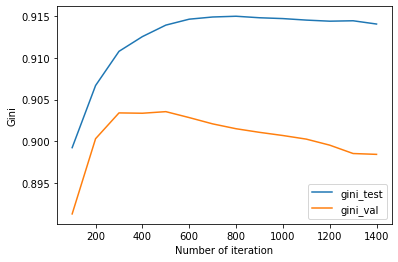

In [532]:
plt.figure()
plt.xlabel("Number of iteration")
plt.ylabel("Gini")
plt.plot(num_iters, gini_test)
plt.plot(num_iters, gini_val)
plt.legend(['gini_test','gini_val'])
plt.show()

In [550]:
params['num_iterations'] = 500
params['scale_pos_weight'] = 2.5
estimator.set_params(**params).fit(x_train1,y_train1)

LGBMClassifier(learning_rate=0.01, max_depth=10, n_jobs=12, num_iterations=500,
               num_leaves=30, random_state=2, scale_pos_weight=2.5)

In [551]:
pr = 0.5
y_train_prob = estimator.predict_proba(x_train1)[:,1] 
y_test_prob = estimator.predict_proba(x_test1)[:,1] 
y_val_prob = estimator.predict_proba(x_valid)[:,1]

y_train_pred = np.where(y_train_prob >= pr,1,0) 
y_test_pred = np.where(y_test_prob >= pr,1,0)
y_val_pred = np.where(y_val_prob >= pr,1,0)

train_metrics = [np.round(precision_score(y_train1, y_train_pred),3)
,np.round(recall_score(y_train1, y_train_pred),3)
, np.round(accuracy_score(y_train1, y_train_pred),3)
,np.round(roc_auc_score(y_train1, y_train_prob),3)
,np.round(2*roc_auc_score(y_train1, y_train_prob)-1,3)]

test_metrics = [np.round(precision_score(y_test1, y_test_pred),3)
,np.round(recall_score(y_test1, y_test_pred),3)
, np.round(accuracy_score(y_test1, y_test_pred),3)
,np.round(roc_auc_score(y_test1, y_test_prob),3)
,np.round(2*roc_auc_score(y_test1, y_test_prob)-1,3)]

val_metrics = [np.round(precision_score(y_valid, y_val_pred),3)
,np.round(recall_score(y_valid, y_val_pred),3)
, np.round(accuracy_score(y_valid, y_val_pred),3)
,np.round(roc_auc_score(y_valid, y_val_prob),3)
,np.round(2*roc_auc_score(y_valid, y_val_prob)-1,3)]

In [552]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
scores = cross_validate(estimator,x_train,y_train, cv=skf,scoring=['precision','recall','roc_auc','accuracy'])

pd.DataFrame({'test_precision' : scores['test_precision'],'test_recall' : scores['test_recall'],\
                    'test_roc_auc' : scores['test_roc_auc']})

,test_precision,test_recall,test_roc_auc
0,0.499140,0.531098,0.957070
1,0.504235,0.544512,0.962459
2,0.497717,0.532032,0.958365


In [553]:
cross = [np.round(scores['test_precision'].mean(),4),np.round(scores['test_recall'].mean(),4),np.round(scores['test_accuracy'].mean(),4),
np.round(scores['test_roc_auc'].mean(),4),np.round(2*scores['test_roc_auc'].mean()-1,4)]
pd.DataFrame({'metrics' : ['precision','recall','accuracy','roc_auc','gini'],'train': train_metrics,
             'test' : test_metrics, 'val' : val_metrics,'cross_val_score' : cross})

,metrics,train,test,val,cross_val_score
0,precision,0.573,0.483,0.548,0.5004
1,recall,0.623,0.523,0.456,0.5359
2,accuracy,0.976,0.971,0.968,0.9720
3,roc_auc,0.981,0.957,0.952,0.9593
4,gini,0.962,0.914,0.904,0.9186


In [538]:
p = 0.5
y_val_pred = np.where(y_val_prob >= p,1,0)

confusion_matrix(y_valid, y_val_pred)

array([[1097699,   15280],
       [  22078,   18542]])

In [416]:
#r = estimator.fit(x_train1,y_train1)

In [417]:
#запись в pickle
'''with open('estimator_block2608_2.pickle', 'wb') as f:
    pickle.dump(r,f)

with open('columns_block2608_2.pickle', 'wb') as f:
    pickle.dump(x_train1.columns,f)'''